# Social Media Sentiment Analysis using Twitter Dataset

In [1]:
#IMPORTING THE LIBRARIES

import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
import pickle






In [7]:
#LOADING THE DATASET

train = pd.read_csv(r'data\train_tweet.csv')
print(train.shape)


(31962, 3)


In [8]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [9]:
train.isnull().any()

id       False
label    False
tweet    False
dtype: bool

In [10]:
#checking out the POSITIVE comments from the train set

train[train['label'] == 0].head()


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [11]:
# checking out the NEGATIVE comments from the train set 

train[train['label'] == 1].head()

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'buil...
14,15,1,no comment! in #australia #opkillingbay #se...
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'...


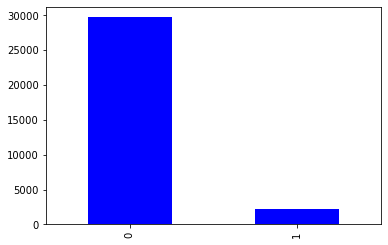

In [13]:
train['label'].value_counts().plot.bar(color = 'blue', figsize = (6, 4))

In [14]:
train.groupby('label').describe()

id                                                               \
         count          mean          std   min      25%      50%       75%   
label                                                                         
0      29720.0  15974.454441  9223.783469   1.0  7981.75  15971.5  23965.25   
1       2242.0  16074.896075  9267.955758  14.0  8075.25  16095.0  24022.00   

                
           max  
label           
0      31962.0  
1      31961.0

# Tweets Preprocessing and Cleaning

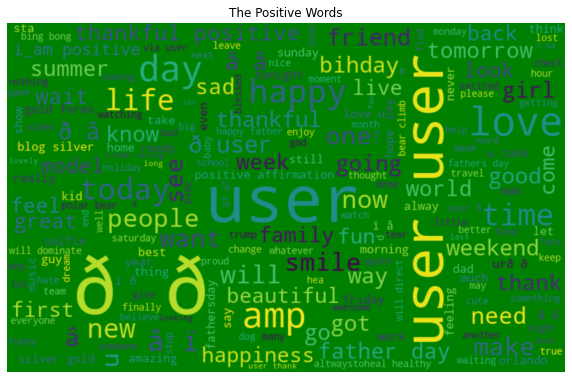

In [15]:
from wordcloud import WordCloud
normal_words =' '.join([text for text in train['tweet'][train['label'] == 0]])

wordcloud = WordCloud(background_color = 'green', width=800, height=500, random_state = 0, max_font_size = 110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="gaussian")
plt.axis('off')
plt.title('The Positive Words')
plt.show()


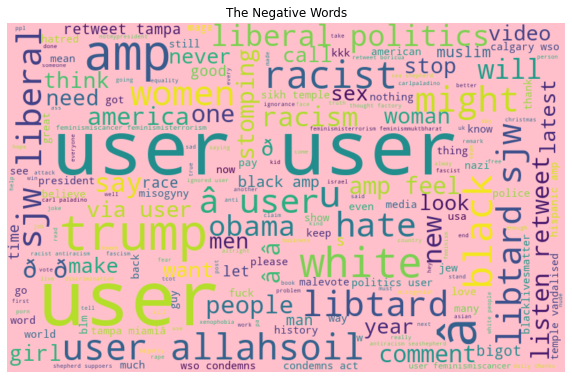

In [18]:
negative_words =' '.join([text for text in train['tweet'][train['label'] == 1]])

wordcloud = WordCloud(background_color = 'pink', width=800, height=500, random_state = 0, max_font_size = 110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Negative Words')
plt.show()

In [13]:
def hashtag_extract(x):
    hashtags = []
    
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [14]:

HT_positive = hashtag_extract(train['tweet'][train['label'] == 0])
HT_negative = hashtag_extract(train['tweet'][train['label'] == 1])
HT_positive = sum(HT_positive,[])
HT_negative = sum(HT_negative,[])

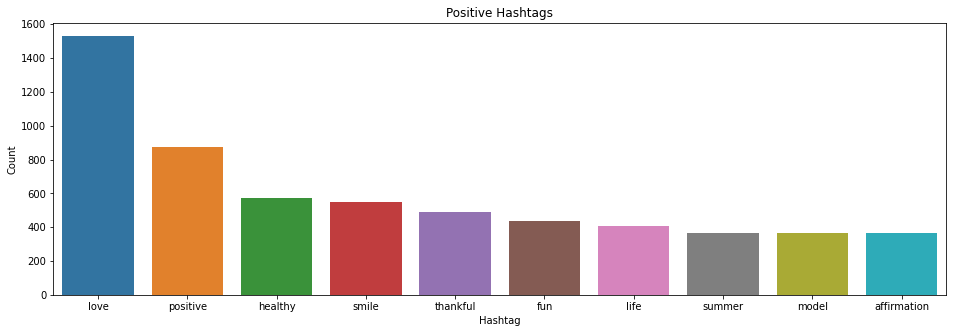

In [15]:
a = nltk.FreqDist(HT_positive)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

  
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.title("Positive Hashtags")
plt.show()

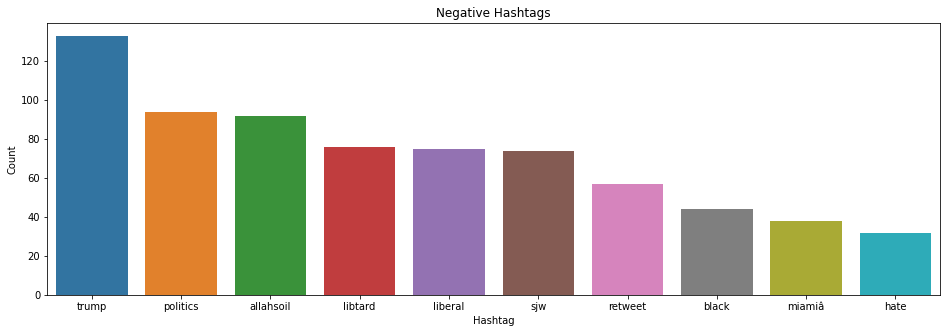

In [16]:
a = nltk.FreqDist(HT_negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.title("Negative Hashtags")
plt.show()

In [17]:
# tokenizing the words present in the training set
tokenized_tweet = train['tweet'].apply(lambda x: x.split()) 
print(tokenized_tweet)


0        [@user, when, a, father, is, dysfunctional, an...
1        [@user, @user, thanks, for, #lyft, credit, i, ...
2                                  [bihday, your, majesty]
3        [#model, i, love, u, take, with, u, all, the, ...
4                 [factsguide:, society, now, #motivation]
                               ...                        
31957    [ate, @user, isz, that, youuu?ðððð...
31958    [to, see, nina, turner, on, the, airwaves, try...
31959    [listening, to, sad, songs, on, a, monday, mor...
31960    [@user, #sikh, #temple, vandalised, in, in, #c...
31961                [thank, you, @user, for, you, follow]
Name: tweet, Length: 31962, dtype: object


In [18]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models.doc2vec import LabeledSentence

In [19]:
def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(LabeledSentence(s, ["tweet_" + str(i)]))
    return output

# label all the tweets
labeled_tweets = add_label(tokenized_tweet)

labeled_tweets[:6]

<ipython-input-19-c4d4182b25a0>:4: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  output.append(LabeledSentence(s, ["tweet_" + str(i)]))


[LabeledSentence(words=['@user', 'when', 'a', 'father', 'is', 'dysfunctional', 'and', 'is', 'so', 'selfish', 'he', 'drags', 'his', 'kids', 'into', 'his', 'dysfunction.', '#run'], tags=['tweet_0']),
 LabeledSentence(words=['@user', '@user', 'thanks', 'for', '#lyft', 'credit', 'i', "can't", 'use', 'cause', 'they', "don't", 'offer', 'wheelchair', 'vans', 'in', 'pdx.', '#disapointed', '#getthanked'], tags=['tweet_1']),
 LabeledSentence(words=['bihday', 'your', 'majesty'], tags=['tweet_2']),
 LabeledSentence(words=['#model', 'i', 'love', 'u', 'take', 'with', 'u', 'all', 'the', 'time', 'in', 'urð\x9f\x93±!!!', 'ð\x9f\x98\x99ð\x9f\x98\x8eð\x9f\x91\x84ð\x9f\x91', 'ð\x9f\x92¦ð\x9f\x92¦ð\x9f\x92¦'], tags=['tweet_3']),
 LabeledSentence(words=['factsguide:', 'society', 'now', '#motivation'], tags=['tweet_4']),
 LabeledSentence(words=['[2/2]', 'huge', 'fan', 'fare', 'and', 'big', 'talking', 'before', 'they', 'leave.', 'chaos', 'and', 'pay', 'disputes', 'when', 'they', 'get', 'there.', '#allshowandn

In [20]:
import re
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer


[nltk_data] Downloading package stopwords to C:\Users\ANAND
[nltk_data]     KUMAR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
train_corpus = []

for i in range(0, 31962):
  review = re.sub('[^a-zA-Z]', ' ', train['tweet'][i])
  review = review.lower()
  review = review.split()
  
  ps = PorterStemmer()
  

  review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
  
  # joining them back with space
  review = ' '.join(review)
  train_corpus.append(review)


# Converting text into numbers


In [22]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features = 10000)
x = cv.fit_transform(train_corpus).toarray()
y = train.iloc[:, 1]

print(x.shape)
print(y.shape)


(31962, 10000)
(31962,)


In [23]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.25, random_state = 42)

print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(23971, 10000)
(7991, 10000)
(23971,)
(7991,)


In [24]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_valid = sc.transform(x_valid)

# Using algorithms for predictions

In [25]:
print(x_train.shape)
print(x_valid.shape)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

model = RandomForestClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("F1 score :", f1_score(y_valid, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)



(23971, 10000)
(7991, 10000)
Training Accuracy : 0.9996662634016102
Validation Accuracy : 0.9607057940182706
F1 score : 0.6557017543859649
[[7378   54]
 [ 260  299]]


In [26]:
print(x_train.shape)
print(x_valid.shape)
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

(23971, 10000)
(7991, 10000)
C:\Python\Python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[21:53:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy : 0.961495139960786
Validation Accuracy : 0.9560755850331623
f1 score : 0.5846153846153846
[[7393   39]
 [ 312  247]]


In [27]:
print(x_train.shape)
print(x_valid.shape)
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=10000)
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)


(23971, 10000)
(7991, 10000)
Training Accuracy : 0.9992908097284219
Validation Accuracy : 0.9391815792766862
f1 score : 0.5996705107084019
[[7141  291]
 [ 195  364]]


In [28]:
X=train['tweet']
tfidf=TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X=tfidf.fit_transform(X)
y=train['label']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)
print(X_train.shape)
print(X_test.shape)
clf=LinearSVC()
clf.fit(X_train, y_train)
print("Validation Accuracy :",clf.score(X_test,y_test))
y_pred=clf.predict(X_test)

print("f1 score :", f1_score(y_test, y_pred))

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

(25569, 10000)
(6393, 10000)
Validation Accuracy : 0.9646488346629125
f1 score : 0.6771428571428572
[[5930   55]
 [ 171  237]]


# Give an input to check


In [46]:
x ='ugly'
vec= tfidf.transform([x])

In [47]:
check=clf.predict(vec)

if check == [0]:
   print("positive")
else:
   print("negative")

negative


# Saving model in file using pickle

In [ ]:
filename = r'models/finalized_model.sav'
pickle.dump(clf, open(filename, 'wb'))
pickle.dump(tfidf, open('count_tfid', 'wb'))

# Loading model from pickle file

In [5]:
filename = r'models/finalized_model.sav'

loaded_model = pickle.load(open(filename, 'rb'))
count_vect = pickle.load(open('models/count_tfid', 'rb'))
result = loaded_model.predict(count_vect.transform(['ugly']))

C:\Users\rajes\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LinearSVC from version 0.24.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\rajes\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.24.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\rajes\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.24.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [6]:
if result == [0]:
   print("positive")
else:
   print("negative")

negative
